In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nb_005 import *

# Faces

## Setup

Download the dataset [here](https://download.pytorch.org/tutorial/faces.zip) from the pytoch tutorial on transforms. Unzip it in the data directory, so that data/faces/ contains the images and the csv file.

In [3]:
PATH = Path('data/faces/')

In [4]:
img_fns = get_image_files(PATH)
img_fns = [fn for fn in img_fns if str(fn)[-3:] == 'jpg']
len(img_fns)

69

In [5]:
import pandas as pd
poses = pd.read_csv(PATH/'face_landmarks.csv')

Reading the coordinates. We adopt pytorch convention in grid_sampler where the coordinates are normalized between -1 and 1. (-1,-1) is the top left corner, (1,1) the bottom right. 

In [7]:
pose_pnts = []
for i, fname in enumerate(img_fns):
    w,h = PIL.Image.open(fname).size
    coords = np.array(poses[poses['image_name'] == fname.name].iloc[0][1:], dtype=np.float32)
    coords = torch.tensor(coords).view(-1,2)
    coords.div_(torch.tensor([w/2,h/2])[None]).add_(-1)
    pose_pnts.append(coords)

In [8]:
len(pose_pnts)

69

In [9]:
pose_pnts[0].shape

torch.Size([68, 2])

Let's have a look at the data.

In [10]:
def show_pose(img, pnts, ax=None):
    if ax is None: _,ax = plt.subplots()
    ax.imshow(img)
    w,h = img.size
    pnts = (pnts.numpy() + 1) * np.array([w/2,h/2])[None]
    ax.scatter(pnts[:, 0], pnts[:, 1], s=10, marker='.', c='r')

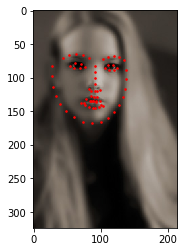

In [13]:
img = PIL.Image.open(img_fns[0])
show_pose(img, pose_pnts[0])

So when we change the picture, the points must be changed accordingly!

In [11]:
@dataclass
class CoordTargetDataset(Dataset):
    x_fns:List[Path]; coords:List[List[float]]
    def __post_init__(self): assert len(self.x_fns)==len(self.coords)
    def __repr__(self): return f'{type(self).__name__} of len {len(self.x_fns)}'
    def __len__(self): return len(self.x_fns)
    def __getitem__(self, i): return open_image(self.x_fns[i]), self.coords[i]

In [12]:
img_ds = CoordTargetDataset(img_fns, pose_pnts)

## Transforms

In [ ]:
def affine_mult(c,m):
    if m is None: return c
    size = c.size()
    _,h,w,_ = size
    m[0,1] *= h/w
    m[1,0] *= w/h
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t())
    return c.view(size)

In [82]:
def affine_inv_mult(c,m, shape):
    "Applies the inverse affine transform described in m"
    size = c.size()
    _,h,w = shape
    m[0,1] *= h/w
    m[1,0] *= w/h
    c = c.view(-1,2)
    a = torch.inverse(m[:2,:2].t()) 
    c = torch.addmm(-torch.mv(a,m[:2,2]), c, a) 
    return c.view(size)

In [91]:
def apply_pad_coords(c, padding_mode='reflect', **kwargs):
    "Apply the padding mode to the coords"
    if padding_mode=='zeros' or padding_mode=='border':
        mask = (c[:,0] >=-1) * (c[:,0] <=1) * (c[:,1] >=-1) * (c[:,1] <=1)
        return c[mask]
    elif padding_mode=='reflect':
        c[c < -1] = -2 - c[c < -1]
        c[c > 1] = 2  - c[c > 1]
    return c

In [92]:
#export
class ImagePoints():
    def __init__(self, pts, shape):
        self._flow=pts
        self._affine_mat=None
        self.sample_kwargs = {}
        self._shape = shape

    @property
    def shape(self): return self._shape
    
    def __repr__(self): return f'{self.__class__.__name__} ({self.shape})'

    @property
    def px(self):
        return self.flow
    @px.setter
    def px(self,v): self._px=v

    @property
    def flow(self):
        if self._flow is None:
            self._flow = affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = affine_inv_mult(self._flow,self._affine_mat,self._shape)
            self._flow = apply_pad_coords(self._flow, **self.sample_kwargs)
            self._affine_mat = None
            
        return self._flow
    @flow.setter
    def flow(self,v): self._flow=v

    def lighting(self, func, *args, **kwargs):
        return self
    
    #TODO: special func for points
    def pixel(self, func, *args, **kwargs):
        self.px = func(self.px, *args, **kwargs)
        return self

    def coord(self, func, *args, **kwargs):
        self.flow = func(self.flow, self.shape, *args, invert=True, **kwargs)
        return self

    def affine(self, func, *args, **kwargs):
        m = func(*args, **kwargs)
        self.affine_mat = self.affine_mat @ self._flow.new(m)
        return self

    def set_sample(self, **kwargs):
        self.sample_kwargs = kwargs
        return self

    def resize(self, size):
        assert self._flow is None
        if isinstance(size, int): size=(self.shape[0], size, size)
        self.flow = affine_grid(size)
        return self

    @property
    def affine_mat(self):
        if self._affine_mat is None: self._affine_mat = self._flow.new(torch.eye(3))
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v): self._affine_mat=v
    
    def clone(self): return self.__class__(self.flow.clone(), self.shape)

In [93]:
def apply_tfms(tfms, x, do_resolve=True, xtra=None, size=None, is_coord=False, x_sz=None, **kwargs):
    if not tfms: return x
    if not xtra: xtra={}
    tfms = sorted(listify(tfms), key=lambda o: o.tfm.order)
    if do_resolve: resolve_tfms(tfms)
    x = Image(x.clone()) if not is_coord else ImagePoints(x.clone(), x_sz)
    if kwargs: x.set_sample(**kwargs)
    if size: x.resize(size)
    for tfm in tfms:
        if tfm.tfm in xtra: x = tfm(x, **xtra[tfm.tfm])
        else:               x = tfm(x)
    return x.px

In [94]:
TfmY = IntEnum('TfmY', 'No Pixel Mask Coord BBox')

class DatasetTfm(Dataset):
    def __init__(self, ds:Dataset, tfms:Collection[Callable]=None, tfm_y:TfmY=TfmY.No, **kwargs):
        self.ds,self.tfms,self.tfm_y,self.kwargs = ds,tfms,tfm_y,kwargs
        
    def __len__(self): return len(self.ds)
    def __getattr__(self, k): return getattr(self.ds, k)
    
    def __getitem__(self,idx):
        if isinstance(idx, tuple): idx,xtra = idx
        else: xtra={}
        x,y = self.ds[idx]
        if self.tfm_y == TfmY.Coord: x_sz = x.size()
        x = apply_tfms(self.tfms, x, **{**self.kwargs, **xtra})
        if self.tfm_y == TfmY.Coord: y = apply_tfms(self.tfms, y, do_resolve=False, is_coord=True, x_sz=x_sz, 
                                                    **{**self.kwargs, **xtra})
        return x, y

In [95]:
tfms = [rotate(degrees=(-30,30.))]

In [96]:
tfm_ds = DatasetTfm(img_ds, tfms, TfmY.Coord, padding_mode='zeros')

In [97]:
def show_pose(img, pnts, ax=None):
    if ax is None: _,ax = plt.subplots()
    ax.imshow(img.numpy().transpose(1,2,0))
    w,h = img.size(2),img.size(1)
    if len(pnts) != 0:
        pnts = (pnts.numpy() + 1) * np.array([w/2,h/2])[None]
        ax.scatter(pnts[:, 0], pnts[:, 1], s=10, marker='.', c='r')

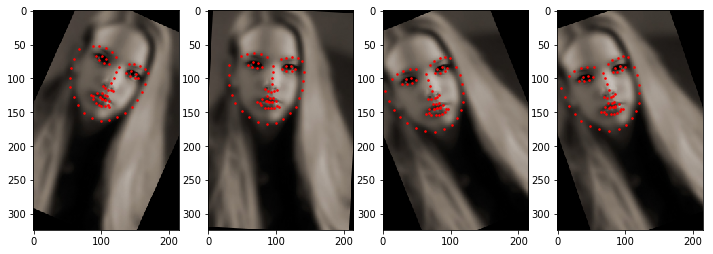

In [99]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

In [103]:
tfms = [zoom(scale=(1,2),row_pct=(0,1),col_pct=(0,1))]

In [110]:
tfm_ds = DatasetTfm(img_ds, tfms, TfmY.Coord, padding_mode='reflect')

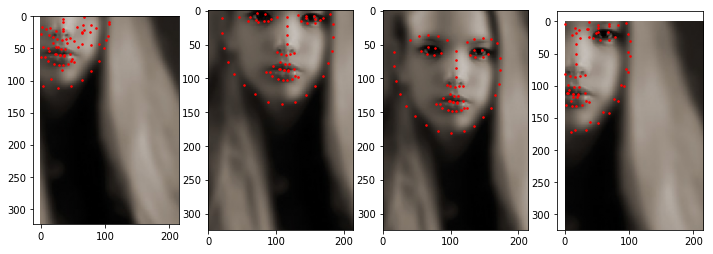

In [111]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

Affine, coords, crop transform first.

In [16]:
def apply_pad_coords(c, padding_mode):
    "Apply the padding mode to the coords"
    if padding_mode=='zeros' or padding_mode=='border':
        mask = (c[:,0] >=-1) * (c[:,0] <=1) * (c[:,1] >=-1) * (c[:,1] <=1)
        return c[mask]
    elif padding_mode=='reflect':
        c[c < -1] = -2 - c[c < -1]
        c[c > 1] = 2  - c[c > 1]
    return c

In [17]:
def affine_inv_mult(c,m):
    "Applies the inverse affine transform described in m"
    size = c.size()
    c = c.view(-1,2)
    a = torch.inverse(m[:2,:2].t()) 
    c = torch.addmm(-torch.mv(a,m[:2,2]), c, a) 
    return c.view(size)

- Problem in affine: we must apply the inverse tranformation (affine_inv_mult function)
- Problem in coord: we must also apply the inverse transformation (flag invert)
- Probem in crop (and other transforms and the beginning): we need the size of the image where as if the object pass is a list of points, it doesn't have it. To work around this, we create a class that will wrap the list of points and the image size, with a function size (to mimic the behavior of img.size())

In [19]:
@dataclass 
class TargetCoords():
    coords:Tensor
    img_size:torch.Size
    
    def size(self, int=None) -> Union[int,torch.Size]: 
        if int is None: return self.img_size
        else:           return self.img_size[int]
        
    def clone(self): return TargetCoords(self.coords.clone(), self.img_size)

In [20]:
tc = TargetCoords(pose_pnts[0], open_image(img_fns[0]).size())

In [21]:
tc.size(), tc.size(1)

(torch.Size([3, 324, 215]), 324)

In [ ]:
TfmY = IntEnum('TfmY', 'No Pixel Mask Coord BBox')

class DatasetTfm(Dataset):
    def __init__(self, ds:Dataset, tfms:Collection[Callable]=None, tfm_y:TfmY=TfmY.No, **kwargs):
        self.ds,self.tfms,self.tfm_y,self.kwargs = ds,tfms,tfm_y,kwargs
        
    def __len__(self): return len(self.ds)
    def __getattr__(self, k): return getattr(self.ds, k)
    
    def __getitem__(self,idx):
        if isinstance(idx, tuple): idx,xtra = idx
        else: xtra={}
        x,y = self.ds[idx]
        if self.tfm_y == TfmY.Coord: y = TargetCoords(y, x.size())
        x = apply_tfms(self.tfms, x, **{**self.kwargs, **xtra})
        if self.tfm_y == TfmY.Coord: y = apply_tfms(self.tfms, y, do_resolve=False, is_coord=coord, x_sz=x.size(), 
                                                    **{**self.kwargs, **xtra})
        return apply_tfms(self.tfms, x, **{**self.kwargs, **xtra}), y

In [22]:
TfmY = IntEnum('TfmY', 'No Pixel Mask Coord BBox')

class TfmDataset(Dataset):
    def __init__(self, ds:Dataset, tfms:Collection[Callable]=None, tfm_y:TfmY=TfmY.No, **kwargs):
        self.ds,self.tfms,self.tfm_y,self.kwargs = ds,tfms,tfm_y,kwargs

    def __len__(self): return len(self.ds)

    def __getitem__(self,idx):
        x,y = self.ds[idx]
        if self.tfms is not None:
            tfm = apply_tfms(self.tfms)
            if self.tfm_y == TfmY.Coord: y = TargetCoords(y, x.size())
            x = apply_tfms(self.tfms, x, **self.kwargs)
            if self.tfm_y != TfmY.No and y is not None:
                coord,seg = (self.tfm_y == TfmY.Coord),(self.tfm_y == TfmY.Mask)
                y = tfm(y, segmentation=seg, is_coord=coord, **self.kwargs).coords
        return x,y

In [23]:
def get_resize_target(img_sz, crop_target, do_crop=False):
    if crop_target is None: return None
    ch,r,c = img_sz
    target_r,target_c = crop_target
    ratio = (min if do_crop else max)(r/target_r, c/target_c)
    return ch,round(r/ratio),round(c/ratio)

In [24]:
def _apply_affine(img, size=None, padding_mode='reflect', do_crop=False, aspect=None, mult=32,
                  mats=None, func=None, crop_func=None, is_coord=False, **kwargs):
    if size is not None and not is_listy(size):
        size = listify(size,2) if aspect is None else get_crop_target(size, aspect, mult)
    if (not mats) and func is None and size is None: return img
    resize_target = get_resize_target(img.size(), size, do_crop=do_crop)
    c = img.coords if is_coord else affine_grid(img, torch.eye(3), size=resize_target)
    if func is not None: c = func(c, img.size(), invert=is_coord)
    if mats:
        m = affines_mat(mats)
        c = affine_mult(c, img.new_tensor(m)) if not is_coord else affine_inv_mult(c, img.coords.new_tensor(m))
    if is_coord:
        if resize_target is None: resize_target = img.size()
        res = TargetCoords(apply_pad_coords(c, padding_mode=padding_mode), torch.Size(resize_target))
    else: 
        res = grid_sample(img, c, padding_mode=padding_mode, **kwargs)
        if padding_mode=='zeros': padding_mode='constant'
    if crop_func is not None: res = crop_func(res, size=size, padding_mode=padding_mode, is_coord=is_coord)
    return res

def apply_affine(mats=None, func=None, crop_func=None):
    return partial(_apply_affine, mats=mats, func=func, crop_func=crop_func)

nb_003a.apply_affine = apply_affine

Test on a rotation

In [20]:
tfms = [rotate(degrees=(-30,30.))]

In [21]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros')

In [22]:
def show_pose(img, pnts, ax=None):
    if ax is None: _,ax = plt.subplots()
    ax.imshow(img.numpy().transpose(1,2,0))
    w,h = img.size(2),img.size(1)
    if len(pnts) != 0:
        pnts = (pnts.numpy() + 1) * np.array([w/2,h/2])[None]
        ax.scatter(pnts[:, 0], pnts[:, 1], s=10, marker='.', c='r')

TypeError: apply_tfms() missing 1 required positional argument: 'x'

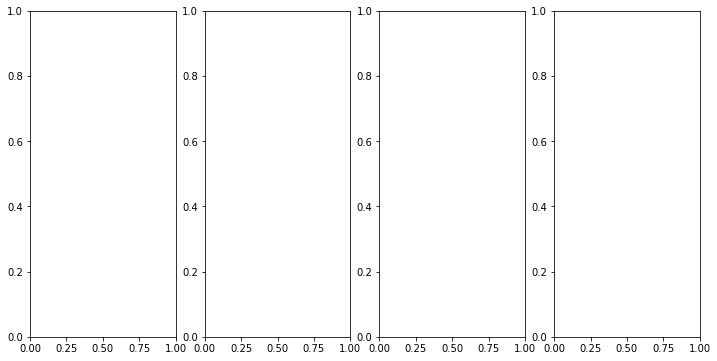

In [23]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

Test on a zoom

In [ ]:
tfms = [zoom_tfm(scale=(1,2),row_pct=(0,1),col_pct=(0,1))]

In [ ]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros', size=100, do_crop=True)

In [ ]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

Whole pipeline: we pass is_coord as an argument to every transform.

In [ ]:
def _apply_tfm_func(pixel_func,lighting_func,affine_func,start_func, x, segmentation=False, is_coord=False, **kwargs):
    if not np.any([pixel_func,lighting_func,affine_func,start_func]): return x
    x = x.clone()
    if start_func is not None:  x = start_func(x, is_coord=is_coord)
    if affine_func is not None: x = affine_func(x, is_coord=is_coord, **kwargs)
    if lighting_func is not None and not segmentation and not is_coord: x = lighting_func(x)
    if pixel_func is not None: x = pixel_func(x, is_coord=is_coord)
    return x

def apply_tfms(tfms):
    resolve_tfms(tfms)
    grouped_tfms = dict_groupby(listify(tfms), lambda o: o.tfm_type)
    start_tfms,affine_tfms,coord_tfms,pixel_tfms,lighting_tfms,crop_tfms = [
        (grouped_tfms.get(o)) for o in TfmType]
    lighting_func = apply_lighting(compose(lighting_tfms))
    mats = [o() for o in listify(affine_tfms)]
    affine_func = apply_affine(mats, func=compose(coord_tfms), crop_func=compose(crop_tfms))
    return partial(_apply_tfm_func,
        compose(pixel_tfms),lighting_func,affine_func,compose(start_tfms))

nb_003a.apply_tfms = apply_tfms

Simple padding

In [ ]:
def pad_coord(x:TargetCoords, row_pad:int, col_pad:int):
    c,h,w = x.size()
    pad = torch.Tensor([w/(w + 2*col_pad), h/(h + 2*row_pad)])
    new_sz = torch.Size([c, h+2*row_pad, w+2*col_pad]) 
    return TargetCoords(x.coords.mul_(pad[None]), new_sz)

In [ ]:
@reg_transform
def pad(x, padding, mode='reflect', is_coord=False) -> TfmType.Start:
    if is_coord: return pad_coord(x, padding, padding)
    else: return F.pad(x[None], (padding,)*4, mode=mode)[0]

In [ ]:
tfms = [pad_tfm(padding=100)]

In [ ]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord)

In [ ]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

Not implemented: the points aren't reflected (is it important?)

Simple crop

In [ ]:
def crop_coords(x:TargetCoords, row:int, col:int, rows:int, cols:int):
    ch,h,w = x.size()
    c = x.coords    
    c.mul_(torch.Tensor([w/cols,h/rows])[None])
    c.add_(-1 + torch.Tensor([w/cols-2*col/cols,h/rows-2*row/rows])[None])
    c = apply_pad_coords(c, padding_mode='zeros')
    new_sz = torch.Size([ch, rows, cols])
    return TargetCoords(c, new_sz)

In [ ]:
@reg_transform
def crop(x, size, is_coord=False, row_pct:uniform=0.5, col_pct:uniform=0.5) -> TfmType.Pixel:
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows+1) * row_pct)
    col = int((x.size(2)-cols+1) * col_pct)
    if is_coord: return crop_coords(x,row,col,rows,cols)
    else:        return x[:, row:row+rows, col:col+cols].contiguous()

In [ ]:
tfms = [crop_tfm(size=200,row_pct=(0,1),col_pct=(0,1))]

In [ ]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord)

In [ ]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

Crop pad transform

In [ ]:
@reg_transform
def crop_pad(x, size, padding_mode='reflect', is_coord=False,
             row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Crop:
    size = listify(size,2)
    rows,cols = size
    if x.size(1)<rows or x.size(2)<cols:
        row_pad = max((rows-x.size(1)+1)//2, 0)
        col_pad = max((cols-x.size(2)+1)//2, 0)
        if is_coord: x = pad_coord(x, row_pad, col_pad)
        else: x = F.pad(x[None], (col_pad,col_pad,row_pad,row_pad), mode=padding_mode)[0]
    
    row = int((x.size(1)-rows+1)*row_pct)
    col = int((x.size(2)-cols+1)*col_pct)
    if is_coord: return crop_coords(x,row,col,rows,cols)
    x = x[:, row:row+rows, col:col+cols]
    return x.contiguous() # without this, get NaN later - don't know why

In [ ]:
tfms = [crop_pad_tfm(row_pct=(0,1),col_pct=(0,1))]

In [ ]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros', do_crop=True, size=100)

In [ ]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

Coord transform (where we see the need for the invert transformation)

In [ ]:
@reg_transform
def tilt(c, img_size, invert=False, direction:rand_int=0, magnitude:uniform=0) -> TfmType.Coord:
    orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]
    if direction == 0:   targ_pts = [[-1,-1], [-1,1], [1,-1-magnitude], [1,1+magnitude]]
    elif direction == 1: targ_pts = [[-1,-1-magnitude], [-1,1+magnitude], [1,-1], [1,1]]
    elif direction == 2: targ_pts = [[-1,-1], [-1-magnitude,1], [1,-1], [1+magnitude,1]]
    elif direction == 3: targ_pts = [[-1-magnitude,-1], [-1,1], [1+magnitude,-1], [1,1]]  
    coeffs = find_coeffs(targ_pts, orig_pts) if invert else find_coeffs(orig_pts, targ_pts)
    return apply_perspective(c, coeffs)

In [ ]:
tfms = [tilt_tfm(direction=(0,3), magnitude=(-0.4,0.4))]

In [ ]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros', do_crop=True, size=100)

In [ ]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)

Flip

In [ ]:
def flip_lr_coord(x):
    x.coords[:,0] = -x.coords[:,0]
    return x

In [ ]:
@reg_transform
def flip_lr(x, is_coord=False) -> TfmType.Pixel: 
    if is_coord: return flip_lr_coord(x)
    else:        return x.flip(2)

In [ ]:
tfms = [flip_lr_tfm(p=0.5)]

In [ ]:
tfm_ds = TfmDataset(img_ds, tfms, TfmY.Coord, padding_mode='zeros', do_crop=True, size=100)

In [ ]:
_,axs = plt.subplots(1,4, figsize=(12,6))
for i,ax in enumerate(axs): show_pose(*tfm_ds[0], ax=ax)